In [2]:
import pandas as pd
import numpy as np
from pyensembl import EnsemblRelease
data = EnsemblRelease(110)
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'path'
from matplotlib import cm
from matplotlib import colors

In [4]:
#load the sample table and all the norm spec files
master_table = pd.read_csv("firstrunredo_FullRNASeqSummaryAnalysis_ot.csv")
file_names = master_table["Original Sample ID"].values
norm_spec_dfs = {}
for file in file_names:
    if "CriCTS" in str(file):
        # norm_spec_dfs[file] = pd.read_csv("redo_normspec/"+file+"normalizedspecificity.csv",header=0,index_col=0)
        norm_spec_dfs[file] = pd.read_csv(file+"normalizedspecificity.csv",header=0,index_col=0)
total_reads = master_table["totalfinal"].values
splice_junctions = master_table["splice junctions"].values
effs = master_table["Efficiency:"].values
ciss = master_table["Cis Count:"].values
transs = master_table["Trans Count:"].values
targets = master_table["Target"].values

In [5]:
#info for each target
reporter_cargo = "gttaatcgaattgaactgaa".upper()
endogenous_cargo = "tccggcagcgaaacccctgg".upper()
cd40l_cargo = "gtcgaagaggaagtaaacct".upper()

gene_dict = {
    "Reporter" : {
        "cargo_seq" : reporter_cargo,
        "off_targ_nt" : 1943,
        "cis_chrom" : "chr25",
        "cis_sd" : 1398,
        "cis_sa" : 1942,
        "trans_chrom" : "chr25",
        "trans_sd" : 1398,
        "trans_sa" : 1942,
        "strand" : 1
    },
    "ITGB1" : {
        "cargo_seq" : endogenous_cargo,
        "off_targ_nt" : 1006,
        "cis_chrom" : "chr10",
        "cis_sd" : 32922736,
        "cis_sa" : 32923584,
        "trans_chrom" : "ITGB1_trans",
        "trans_sd" : 157,
        "trans_sa" : 1005,
        "strand" : 2
    },
    "SMARCA4" : {
        "cargo_seq" : endogenous_cargo,
        "off_targ_nt" : 6394,
        "cis_chrom" : "chr19",
        "cis_sd" : 11035133,
        "cis_sa" : 11041306,
        "trans_chrom" : "SMARCA4_trans",
        "trans_sd" : 220,
        "trans_sa" : 6393,
        "strand" : 2
    },
    "TFRC" : {
        "cargo_seq" : endogenous_cargo,
        "off_targ_nt" : 1931,
        "cis_chrom" : "chr3",
        "cis_sd" : 196069569,
        "cis_sa" : 196071395,
        "trans_chrom" : "TFRC_trans",
        "trans_sd" : 104,
        "trans_sa" : 1930,
        "strand" : 1
    },
    "CD40L" : {
        "cargo_seq" : cd40l_cargo,
        "off_targ_nt" : 1888,
        "cis_chrom" : "CD40LCis",
        "cis_sd" : 234,
        "cis_sa" : 1887,
        "trans_chrom" : "CD40LTrans",
        "trans_sd" : 234,
        "trans_sa" : 1887,
        "strand" : 1
    }
}

In [6]:
#helper functions for getting the genes for each off target and for filtering
def get_genes_for_df(df,total_reads=100000000):
    chrs,sds,ots = df.loc[:,"Chromosome"].values, df.loc[:,"Splice Donor"].values,100000000*df.loc[:,"Number of Off-targets"].values/total_reads
    for ch in chrs:
        if not "chr" in ch:
            print(ch)
    chrs_clean = [ch.split("chr")[1] for ch in chrs]
    genes_dict = {}
    #find gene that is located at off-target loci
    for ch,sd,ot in zip(chrs_clean,sds,ots):
        sd = int(sd)
        genes_found = data.genes_at_locus(contig=ch,position=sd)
        if len(genes_found)>0:
            gene_id = genes_found[0].id
            genes_dict[gene_id] = ot
    return genes_dict
def get_exons_for_df(df):
    # df = df.loc[df["Number of Off-targets"] > 2]
    print(len(df["Chromosome"].values))
    chrs,sds,strands = df.loc[:,"Chromosome"].values, df.loc[:,"Splice Donor"].values, df.loc[:,"Strand"].values
    for ch in chrs:
        if not "chr" in ch:
            print(ch)
    chrs_clean = [ch.split("chr")[1] for ch in chrs]
    exons = []
    #find gene that is located at off-target loci
    for ch,sd,strand in zip(chrs_clean,sds,strands):
        if strand == 1:
            pos = int(sd) - 1
        else:
            pos = int(sd) + 1
        exons_found = data.exons_at_locus(contig=ch,position=pos)
        if len(exons_found)>0:
            exons.append(exons_found[0])
    return exons
def filter_df(df,cis_count = True, trans_count = True, by_exon = True, norm_counts = False, total_counts = 100000000,add_ontarget = False, ontarget_data = [],norm_ratio = 1.0):
    df = df.copy()
    df["Is On-target"] = len(df.index)*[False]
    if add_ontarget:
        df.loc[len(df.index)] = ontarget_data
    if norm_counts:
        df["Number of Normalized Off-target Reads"] = df["Number of Off-targets"]/norm_ratio
        df["Number of Normalized Cis Junction Reads"] = df["Number of Cis Junctions"]/norm_ratio
    if cis_count and trans_count:
        filtered_df = df.loc[(df["Number of Normalized Off-target Reads"] >= 3) & (df["Number of Normalized Cis Junction Reads"] >= 3)].copy()
    elif trans_count:
        filtered_df = df.loc[df["Number of Off-targets"] >= 3].copy()
    elif cis_count:
        filtered_df = df.loc[df["Number of Cis Junctions"] >= 3].copy()
    else:
        filtered_df = df.copy()
    chrs,sds,strands,is_on_targets = filtered_df.loc[:,"Chromosome"].values, filtered_df.loc[:,"Splice Donor"].values, filtered_df.loc[:,"Strand"].values, filtered_df.loc[:,"Is On-target"].values
    chrs_clean = [ch.split("chr")[1] for ch in chrs if "chr" in ch]
    exon_exists = []
    if by_exon:
        for ch,sd,strand,on_target in zip(chrs_clean,sds,strands,is_on_targets):
            if strand == 1:
                pos = int(sd) - 1
            else:
                pos = int(sd) + 1
            exons_found = data.exons_at_locus(contig=ch,position=pos)
            if len(exons_found)>0:
                exon_exists.append(True)
            elif on_target:
                exon_exists.append(True)
            else:
                exon_exists.append(False)
        final_filtered = filtered_df.loc[exon_exists]
    else:
        final_filtered = filtered_df
    return final_filtered
def join_dfs(genes_list,gene_dict = {},method="join"):
    def get_gene_id(gene):
            if isinstance(gene,str):
                gene_id = gene
            else:
                gene_id = gene.id
            return gene_id
    def join_genes(genes,gene_dict):
        for gene in genes.keys():
            gene_id = get_gene_id(gene)
            if gene_id in gene_dict:
                gene_dict[gene_id] = gene_dict[gene_id] + genes[gene_id]
            else:
                gene_dict[gene_id] = genes[gene_id]
    if method == "join":
        for genes in genes_list:
            join_genes(genes,gene_dict)
    elif method == "overlap":
        for i in range(len(genes_list)):
            genes = genes_list[i]
            if len(gene_dict.keys()) == 0:
                join_genes(genes,gene_dict)
            else:
                overlap_dict = {}
                for gene in genes.keys():
                    gene_id = get_gene_id(gene)
                    if gene_id in gene_dict:
                        overlap_dict[gene_id] = gene_dict[gene_id]+genes[gene_id]
                gene_dict = overlap_dict
    return gene_dict
def join_junction_dfs(df_list,df_dict,method="join",use_norm = True):
    def get_junction_key(ch,sd,strand):
        return ch+"splice"+str(sd)+"strand"+str(strand)
    def decode_junction_key(key):
        ch = key.split("chr")[1].split("splice")[0]
        sd = key.split("splice")[1].split("strand")[0]
        strand = key.split("strand")[1]
        return ch,sd,strand
    def get_data(df):
        # print(len(df.index))
        if use_norm:
            return df.loc[:,"Chromosome"].values,df.loc[:,"Splice Donor"].values,df.loc[:,"Strand"].values,df.loc[:,"Number of Normalized Off-target Reads"].values
        else:
            return df.loc[:,"Chromosome"].values,df.loc[:,"Splice Donor"].values,df.loc[:,"Strand"].values,df.loc[:,"Number of Off-targets"].values
    def join_junctions(df,df_dict):
        chs,sds,strands,ots = get_data(df)
        for ch,sd,strand,ot in zip(chs,sds,strands,ots):
            key = get_junction_key(ch,sd,strand)
            if key in df_dict:
                df_dict[key] = ot + df_dict[key]
            else:
                df_dict[key] = ot
    if method == "join":
        for df in df_list:
            join_junctions(df,df_dict)
    elif method=="overlap":
        for i in range(len(df_list)):
            df = df_list[i]
            if len(df_dict.keys()) == 0:
                join_junctions(df,df_dict)
            else:
                overlap_dict = {}
                chs,sds,strands,ots = get_data(df)
                for ch,sd,strand,ot in zip(chs,sds,strands,ots):
                    key = get_junction_key(ch,sd,strand)
                    if key in df_dict:
                        overlap_dict[key] = df_dict[key]+ot
                df_dict = overlap_dict
    return df_dict

def to_file(arr,file):
    with open(file,"w") as f:
        for element in arr:
            f.write(element+"\n")

In [13]:
#ignore
ot_dict = get_genes_for_df(pd.read_csv("CriCTS_009_R1_dCasRx_ITGB1-gTSM_T-gIM_S26normalizedspecificity.csv",index_col=0,header=0))
pd.DataFrame(ot_dict).to_csv("cricts9ot.csv")

ValueError: If using all scalar values, you must pass an index

In [7]:
#Filter the spcificity files from RNA-seq analysis
filtered_dfs = {}
normed_filtered_dfs_no_ontarget = {}
norm_ratio_df = pd.read_csv("norm_ratio.csv")
for file,total,eff,cis,trans,target in zip(file_names,total_reads,effs,ciss,transs,targets):
    print(file)
    df = norm_spec_dfs[file]
    gene_data = gene_dict[target]
    ontarget_data = [gene_data["cis_chrom"],gene_data["strand"],gene_data["cis_sd"],cis,trans,eff,True]
    norm_ratio = norm_ratio_df[file].values[0]
    filtered_dfs[file] = filter_df(df=df,cis_count=True,trans_count=True,by_exon=False,norm_counts=True,total_counts=total,add_ontarget=True,ontarget_data=ontarget_data,norm_ratio=norm_ratio)
    normed_filtered_dfs_no_ontarget[file] = filter_df(df=df,cis_count=True,trans_count=True,by_exon=False,norm_counts=True,total_counts=total,add_ontarget=False,norm_ratio=norm_ratio)


CriCTS_001_R1_dCasRx_ITGB1-gTSM_pUC_S18
CriCTS_002_R2_dCasRx_ITGB1-gTSM_pUC_S19
CriCTS_003_R1_pUC_ITGB1-gTSM_pUC_S20
CriCTS_004_R2_pUC_ITGB1-gTSM_pUC_S21
CriCTS_005_R1_dCasRx_ITGB1-gTSM_NT-gIM_S22
CriCTS_006_R2_dCasRx_ITGB1-gTSM_NT-gIM_S23
CriCTS_007_R1_pUC_ITGB1-gTSM_NT-gIM_S24
CriCTS_008_R2_pUC_ITGB1-gTSM_NT-gIM_S25
CriCTS_009_R1_dCasRx_ITGB1-gTSM_T-gIM_S26
CriCTS_010_R2_dCasRx_ITGB1-gTSM_T-gIM_S27
CriCTS_011_R1_pUC_ITGB1-gTSM_T-gIM_S28
CriCTS_012_R2_pUC_ITGB1-gTSM_T-gIM_S29
CriCTS_013_R1_dCasRx_NT-gTSM_pUC_S30
CriCTS_014_R2_dCasRx_NT-gTSM_pUC_S31
CriCTS_015_R1_pUC_NT-gTSM_pUC_S32
CriCTS_016_R2_pUC_NT-gTSM_pUC_S33
CriCTS_017_R1_dCasRx_NT-gTSM_NT-gIM_S34
CriCTS_018_R2_dCasRx_NT-gTSM_NT-gIM_S35
CriCTS_020_R2_pUC_NT-gTSM_NT-gIM_S37
CriCTS_021_R1_dCasRx_NT-gTSM_T-gIM_S38
CriCTS_022_R2_dCasRx_NT-gTSM_T-gIM_S39
CriCTS_023_R1_pUC_NT-gTSM_T-gIM_S40
CriCTS_024_R2_pUC_NT-gTSM_T-gIM_S41
CriCTS_026_R2_dCasRx_T-gTSM-NT-gIM_SMARCA4-gIM_S43
CriCTS_027_R1_dCasRx_NT-gTSM_SMARCA4-gIM_S44
CriCTS_028_R2

In [8]:
#Code to generate the columns in Tables S1 and S4
filtered_trans_counts = []
normed_filtered_off_target = []
normed_filtered_on_target = []
greater_than_5s = []
eff_less_5 = []
high_eff_less_10 = []
for file in file_names:
    filtered_df = filtered_dfs[file]
    normed_filtered_df = normed_filtered_dfs_no_ontarget[file]
    total_trans_count = np.sum(filtered_df["Number of Off-targets"].values)
    normed_ot = np.sum(normed_filtered_df["Number of Normalized Off-target Reads"].values)
    normed_filtered_off_target.append(normed_ot)
    on_target_list = filtered_df.loc[filtered_df["Is On-target"] == True]["Number of Normalized Off-target Reads"].values
    ot_greater = len(normed_filtered_df.loc[normed_filtered_df["Number of Normalized Off-target Reads"] < 10]["Number of Normalized Off-target Reads"].values)
    ot_eff_less = len(normed_filtered_df.loc[normed_filtered_df["Off-target Efficiency"] < .05]["Off-target Efficiency"].values)
    ot_greater_less = len(normed_filtered_df.loc[(normed_filtered_df["Off-target Efficiency"] >= .05) & (normed_filtered_df["Number of Normalized Off-target Reads"] < 10)]["Off-target Efficiency"].values)
    num_ot_junc = len(normed_filtered_df["Off-target Efficiency"].values)
    num_greater = len(normed_filtered_df.loc[normed_filtered_df["Off-target Efficiency"] >= .05]["Off-target Efficiency"].values)
    if num_ot_junc > 0:
        greater_than_5s.append(100*ot_greater/num_ot_junc)
        eff_less_5.append(100*ot_eff_less/num_ot_junc)
    else:
        greater_than_5s.append("NA")
        eff_less_5.append("NA")
    if num_greater > 0:
        high_eff_less_10.append(100*ot_greater_less/num_greater)
    else:
        high_eff_less_10.append("NA")
    if len(on_target_list) == 0:
        normed_filtered_on_target.append(0)
    else:
        normed_filtered_on_target.append(on_target_list[0])
    filtered_trans_counts.append(total_trans_count)
master_table["Filtered Total Trans Count"] = filtered_trans_counts
master_table["Filtered Normalized Off-target Trans Count"] = normed_filtered_off_target
master_table["Filtered Normalized On-target Trans Count"] = normed_filtered_on_target
master_table["% of Off-targets with Less Than 10 Reads"] = greater_than_5s
master_table["% of Off-targets with Less than 5% Efficiency"] = eff_less_5
master_table["% of Off-targets with greater than 5% Efficiency and less than 10 reads"] = high_eff_less_10
master_table["% of Total Splice Junctions that are Off-target Trans-splicing"] = 100*master_table["Filtered Total Trans Count"]/master_table["splice junctions"]

# master_table.to_csv("20241031_TFRC_FullRNASeqSummaryAnalysis.csv")

In [8]:
#Code layout to perform the overlap comparisons for Tables S2
#Shown example is for calculating the overlaps between each effector for the NT TSM (in Table S2)
effectors = master_table["TSM Effector"].unique().astype("str")
print(effectors)
for effector in effectors:
    tgtsmreporter_comparison = master_table.loc[(master_table["Target"] == "Reporter") & (master_table["TSM"] == "NT") & ((master_table["TSM Effector"].values.astype("str") == "dCasRx") | (master_table["TSM Effector"].values.astype("str") == "nan"))]
    reporter_effector_comp_files = tgtsmreporter_comparison["Original Sample ID"].values
    print("Number of Samples in Comparison: "+str(len(reporter_effector_comp_files)))
    reporter_effector_comp_dfs = [normed_filtered_dfs_no_ontarget[file] for file in reporter_effector_comp_files]
    reporter_effector_comp_reads = tgtsmreporter_comparison["totalfinal"].values
    reporter_effector_comp_genes = [get_genes_for_df(df=df,total_reads=total) for df,total in zip(reporter_effector_comp_dfs,reporter_effector_comp_reads)]
    num_overlapping_junctions = len(join_junction_dfs(df_list=reporter_effector_comp_dfs,df_dict={},method="overlap",use_norm=True))
    num_total_junctions = len(join_junction_dfs(df_list=reporter_effector_comp_dfs,df_dict={},method="join",use_norm=True))
    num_overlapping_genes = len(join_dfs(genes_list=reporter_effector_comp_genes,gene_dict={},method="overlap"))
    num_total_genes = len(join_dfs(genes_list=reporter_effector_comp_genes,gene_dict={},method="join"))


['dCasRx' 'nan' 'dCasRxRBD' 'Hifi' 'HifiRBD']
Number of Samples in Comparison: 4
Number of Samples in Comparison: 4
Number of Samples in Comparison: 4
Number of Samples in Comparison: 4
Number of Samples in Comparison: 4


In [9]:
# Function for generating split legend specificty plots
def sl_spec_plot(df1_filtered,title="test.svg"):
    df1_filtered["Cis-splicing Junction Rank"] = df1_filtered["Number of Cis Junctions"].rank(ascending=True,method="first")
    df1_filtered["Trans-splicing Target Rank"] = df1_filtered["Number of Off-targets"].rank(ascending=False,method="first")
    df1_filtered["Total Reads at Junction"] = df1_filtered["Number of Cis Junctions"] + df1_filtered["Number of Off-targets"]
    df1_filtered["Total Read Rank"] = df1_filtered["Total Reads at Junction"].rank(ascending=True,method="first")
    df1_filtered["Trans-splicing % Efficiency"] = df1_filtered["Off-target Efficiency"]*100
    if "CriCTS_009" in title:
        sns.set(rc={'figure.figsize':(6.85,5.65)})
    else:
        sns.set(rc={'figure.figsize':(3,5)})
    sns.set_style(style='white')
    f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'hspace':0.05})
    contin_scale = sns.color_palette("rocket_r", as_cmap=True)
    # plt.colorbar(cm.ScalarMappable(norm = colors.Normalize(vmin=0,vmax=100),cmap=contin_scale))
    sns.scatterplot(data=df1_filtered,
                    x="Cis-splicing Junction Rank",
                    y="Number of Normalized Off-target Reads",
                    hue="Trans-splicing % Efficiency",
                    edgecolor="none",
                    legend=False,
                    palette = "rocket_r",
                    ax=ax_top,
                    hue_norm = (0,100)
                    )
    sns.scatterplot(data=df1_filtered,
                    x="Cis-splicing Junction Rank",
                    y="Number of Normalized Off-target Reads",
                    hue="Trans-splicing % Efficiency",
                    edgecolor="none",
                    legend=False,
                    palette = "rocket_r",
                    ax=ax_bottom,
                    hue_norm = (0,100)
                    )
    ax_top.set_ylim(70,250)   #edit here for different genes
    ax_bottom.set_ylim(0,70)     #edit here for different genes
    sns.despine(ax=ax_bottom)
    sns.despine(ax=ax_top, bottom=True)
    ax = ax_top
    d = .015  # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax2 = ax_bottom
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    if "svg" in title:
        plt.savefig(title,dpi=1200,transparent=True,format = "svg")
    else:
        plt.savefig(title,dpi=1200,transparent=True,format = "png")
    if len(df1_filtered[df1_filtered["Is On-target"] == True]) == 0:
        return ("NA","NA")
    else:
        return  (df1_filtered.loc[df1_filtered["Is On-target"] == True]["Cis-splicing Junction Rank"].values[0], df1_filtered.loc[df1_filtered["Is On-target"] == True]["Number of Normalized Off-target Reads"].values[0])

In [14]:
# Function for generating continuous legend specificty plots
def spec_plot(df1_filtered,title="title.svg"):
    df1_filtered["Cis-splicing Junction Rank"] = df1_filtered["Number of Cis Junctions"].rank(ascending=True,method="first")
    df1_filtered["Trans-splicing Target Rank"] = df1_filtered["Number of Off-targets"].rank(ascending=False,method="first")
    df1_filtered["Total Reads at Junction"] = df1_filtered["Number of Cis Junctions"] + df1_filtered["Number of Off-targets"]
    df1_filtered["Total Read Rank"] = df1_filtered["Total Reads at Junction"].rank(ascending=True,method="first")
    df1_filtered["Trans-splicing % Efficiency"] = df1_filtered["Off-target Efficiency"]*100
    contin_scale = sns.color_palette("rocket_r", as_cmap=True)
    fig, ax = plt.subplots()
    g = sns.scatterplot(
        data = df1_filtered,
        x="Cis-splicing Junction Rank",
        y="Number of Normalized Off-target Reads",
        hue="Trans-splicing % Efficiency",
        hue_norm = (0,100),
        palette = contin_scale,
        linewidth=0,
        legend = False,
        ax = ax
    )
    if "CriCTS_009" in title:
        print("here")
        sns.set(rc={'figure.figsize':(6.85,5.65)})
    else:
        sns.set(rc={'figure.figsize':(3,5)})
    sns.set_style(style='white')
    ax.set_xlabel("Rank by # of Cis-spliced Junction Reads")
    ax.set_ylabel("Number of Trans-splicing Reads per 100 million")
    ax.set_ylim(0,70)  #edit here for different genes
    if "svg" in title:
        plt.savefig(title,dpi=1200,transparent=True,format = "svg")
    else:
        plt.savefig(title,dpi=1200,transparent=True,format = "png")
    if len(df1_filtered[df1_filtered["Is On-target"] == True]) == 0:
        return ("NA","NA")
    else:
        return  (df1_filtered.loc[df1_filtered["Is On-target"] == True]["Cis-splicing Junction Rank"].values[0], df1_filtered.loc[df1_filtered["Is On-target"] == True]["Number of Normalized Off-target Reads"].values[0])

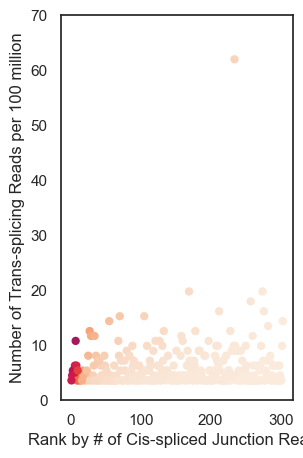

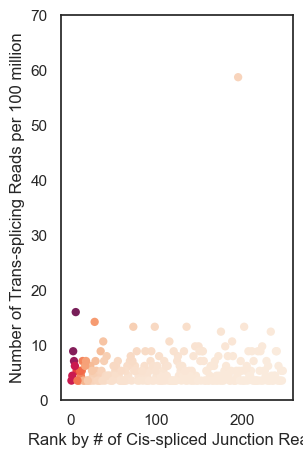

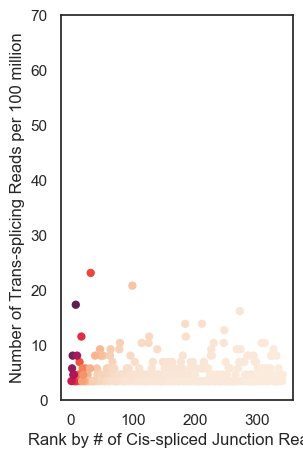

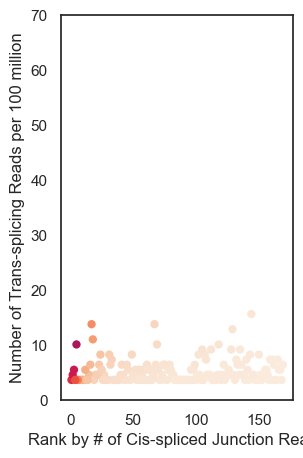

In [15]:
#Example code for generating split-legend plots in Fig. S7
itgb1_files = master_table.loc[master_table["Target"] == "SMARCA4"]["Original Sample ID"].values
plot_metadata = []
for file in itgb1_files:
    title = "firstrunredo_smarcaplots/"+file+".svg"
    meta = spec_plot(filtered_dfs[file],title)
    plot_metadata.append([file,meta[0],meta[1]])
pd.DataFrame(data=plot_metadata,columns=["Prefix","On-target Cis-junction rank","On-target Number of norm TS reads"]).to_csv("first_run_smarca_plot_metadata.csv")

In [11]:
#Code for generating overlap comparisons in Table S5
endo_conds = pd.read_csv("reporter_endogenous_conds.csv")
data_dict = {}
for col in endo_conds.columns.values.astype("str"):
    data_dict[col] = endo_conds[col].values.astype("str")

def filter_for_overlap(i):
    temp_df = master_table.copy()
    for col in endo_conds.columns.values.astype("str"):
        if data_dict[col][i] != "all":
            temp_df = temp_df.loc[temp_df[col].values.astype("str") == data_dict[col][i]]
    return temp_df

junction_overlaps = []
junction_joins = []
gene_overlaps = []
gene_joins = []
num_samples = []

for i in range(len(data_dict["Target"])):
    comparison_df = filter_for_overlap(i)
    comparison_files = comparison_df["Original Sample ID"].values
    num_samples.append(len(comparison_files))
    filtered_comparison_dfs = [normed_filtered_dfs_no_ontarget[file] for file in comparison_files]
    comparison_totals = comparison_df["totalfinal"].values
    comparison_genes = [get_genes_for_df(df=df,total_reads=total) for df,total in zip(filtered_comparison_dfs,comparison_totals)]
    junction_overlaps.append(len(join_junction_dfs(df_list=filtered_comparison_dfs,df_dict={},method="overlap",use_norm=True)))
    junction_joins.append(len(join_junction_dfs(df_list=filtered_comparison_dfs,df_dict={},method="join",use_norm=True)))
    gene_overlaps.append(len(join_dfs(genes_list=comparison_genes,gene_dict={},method="overlap")))
    gene_joins.append(len(join_dfs(genes_list=comparison_genes,gene_dict={},method="join")))

endo_conds["Number of Overlapping Off-target Junctions"] = junction_overlaps
endo_conds["Number of Total Off-target Junctions"] = junction_joins
endo_conds["Number of Overlapping Off-target Genes"] = gene_overlaps
endo_conds["Number of Total Off-target Genes"] = gene_joins
endo_conds["% Overlapping Off-target Junctions"] = 100*np.divide(junction_overlaps,junction_joins)
endo_conds["% Overlapping Off-target Genes"] = 100*np.divide(gene_overlaps,gene_joins)
endo_conds["Number of Samples"] = num_samples
# print(endo_conds.columns)
# endo_conds.columns = np.arange(12)
# print(endo_conds.columns)
endo_conds.to_csv("reporter_Endogenous_Overlap_Counts.csv")
# endo_conds.head(5)

In [ ]:
#Code for generating the plots and values in the Methods section for the distribution of splice junction counts
def plot_sj_dis(file,num_reads):
    sj_df = pd.read_csv(file,sep="\t",header=None)
    sj_raw_counts = sj_df.loc[:,6].values
    sj_norm_counts = 145000000*sj_raw_counts/num_reads
    sj_df["Normalized Counts"] = sj_norm_counts
    sj_df = sj_df.loc[sj_df["Normalized Counts"] >= 3.0]
    print("Percent of Filtered Splice Junctions with Greater than 10 Normalized Reads: "+str(100*len(sj_df.loc[sj_df["Normalized Counts"] > 10])/len(sj_df)))
    sj_df["Log Counts"] = np.log2(sj_df["Normalized Counts"] + 1)
    plt.hist(sj_df["Log Counts"],log=True,bins=75,density=False)
    plt.xlabel("Log Transformed Number of Splice Junction Reads")
    plt.ylabel("Count")
    plt.axvline(np.log2(10+1), color='r') # horizontal line representing 10 normalized splice junction reads
    plt.title("Distribution of Filtered Splice Junctions in the Transcriptome")
    plt.savefig(file.split(".out")[0]+"sjdis.jpg",dpi=1200,format="jpg")
    plt.plot()
    plt.clf()
plot_sj_dis("CriCTS_040_R2_pUC19_pUC_pUC_S57SJ.out.tab",155059082*(1 - .0327 - .0038))
plot_sj_dis("CriCTS_041_R1_dCasRx_Reporter_T-gTSM_S58SJ.out.tab",149465691*(1 - .0338 - .0092))